In [3]:
# General tools
import pandas as pd
import numpy as np
from numpy import where
import matplotlib.pyplot as plt
import seaborn as sns

# For transformations and predictions
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# For the tree visualization
# import pydot
# from IPython.display import Image
# from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score

# For validation
from sklearn.model_selection import train_test_split, cross_val_score,\
    GridSearchCV 


1. Load dataset
2. Pre processing:

  1.   Exploratory data analysis (EDA)
  2.   cleaning


3. Machine learning:

  1.   Get out X and Y
  2.   Split to train/test sets
  3.   Modeling (Random Forest)
  4.   Error metric: mean squared error (mse)
  5.   Accuracy

In [4]:
# Load dataset
wine = pd.read_csv("winequality-red.csv",sep=',')

**EDA**

In [5]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
pd.set_option('float_format', '{:.2f}'.format)
wine.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.00,8.32,1.74,4.60,7.10,7.90,9.20,15.90
volatile acidity,1599.00,0.53,0.18,0.12,0.39,0.52,0.64,1.58
citric acid,1599.00,0.27,0.19,0.00,0.09,0.26,0.42,1.00
residual sugar,1599.00,2.54,1.41,0.90,1.90,2.20,2.60,15.50
chlorides,1599.00,0.09,0.05,0.01,0.07,0.08,0.09,0.61
free sulfur dioxide,1599.00,15.87,10.46,1.00,7.00,14.00,21.00,72.00
total sulfur dioxide,1599.00,46.47,32.90,6.00,22.00,38.00,62.00,289.00
density,1599.00,1.00,0.00,0.99,1.00,1.00,1.00,1.00
pH,1599.00,3.31,0.15,2.74,3.21,3.31,3.40,4.01
sulphates,1599.00,0.66,0.17,0.33,0.55,0.62,0.73,2.00


In [8]:
# unique values of the target quality
wine.quality.unique()

array([5, 6, 7, 4, 8, 3])

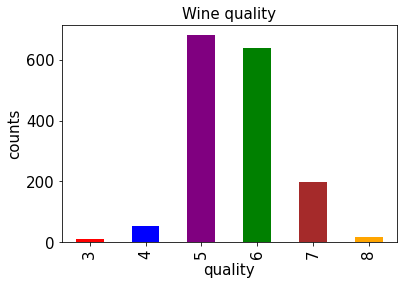

Target quality is slightly imbalanced


In [9]:
# check for imbalanced target quality
ax=wine.groupby(['quality'])['quality'].count().plot.bar(color=['red', 'blue', 'purple', 'green', 'brown', 'orange'])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('quality', fontsize=15)
ax.set_ylabel('counts', fontsize=15)
ax.set_title ('Wine quality', fontsize=15)
plt.show()
plt.close()
print('Target quality is slightly imbalanced')

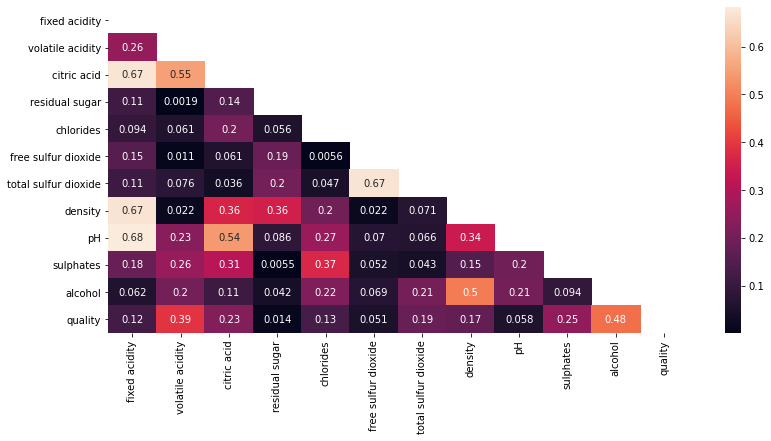

In [10]:
# correlation matrix
fig, ax = plt.subplots(figsize = (13,6))
sns.heatmap(wine.corr().abs(), mask=np.triu(np.ones_like(wine.corr().abs(), dtype=bool,)), annot= True)

In [11]:
# check correlations between the features
corr_matrix = wine.iloc[:,0:11].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

In [12]:
# drop columns with sligtly high correlation
to_drop=[]
for column in upper_tri.columns:
  if any(upper_tri[column] > 0.65):
    to_drop.append(column)
print(to_drop)

['citric acid', 'total sulfur dioxide', 'density', 'pH']


In [13]:
# check correlations of features with the target
correlations_with_target = wine.corr()['quality']
print(abs(correlations_with_target).sort_values(ascending=False)>0.25)

quality                  True
alcohol                  True
volatile acidity         True
sulphates                True
citric acid             False
total sulfur dioxide    False
density                 False
chlorides               False
fixed acidity           False
pH                      False
free sulfur dioxide     False
residual sugar          False
Name: quality, dtype: bool


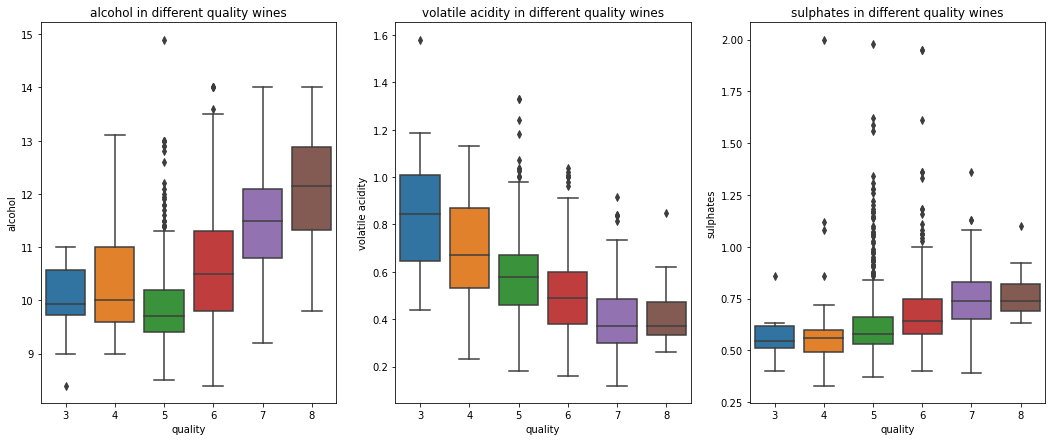

In [14]:
vars=['alcohol', 'volatile acidity', 'sulphates']
fig, axes = plt.subplots(1, 3, figsize=(18, 7))
counter_vars = 0

for i in range(0,3):
    bp = sns.boxplot(ax=axes[i], data=wine, x='quality', y= vars[counter_vars])
    bp.set(title=f"{vars[counter_vars]} in different quality wines")
    counter_vars+=1

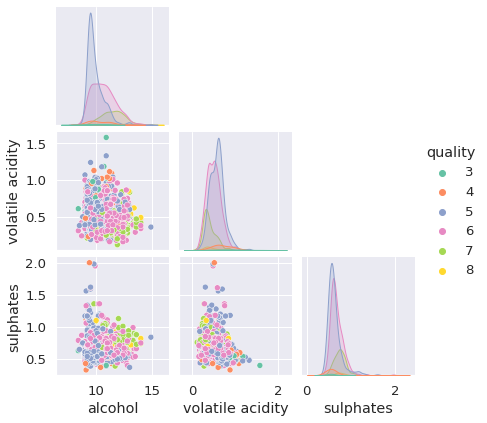

In [15]:
# pairplots of correlated features with the target quality
vars=['alcohol', 'volatile acidity', 'sulphates']
sns.set(font_scale=1.2)
sns.pairplot(wine, 
             vars = vars, 
             hue = 'quality', diag_kind = 'kde',
             height = 2, 
             corner=True,
             aspect=1,
             palette="Set2")

In [16]:
# drop corralated features
wine_original = wine.copy()
wine.drop(to_drop, axis=1, inplace=True)

In [17]:
# some cleaning
Q1=wine.quantile(0.25)
Q3=wine.quantile(0.75)
IQR=Q3-Q1

# removing outliers
wine_clean = wine.copy()

for col in wine_clean.iloc[:,0:7].columns:
        Q1 = wine_clean[col].quantile(0.25)
        Q3 = wine_clean[col].quantile(0.75)
        IQR=Q3-Q1
        wine_clean = wine_clean.loc[(wine_clean[col]>= Q1 - 2.7 * IQR)&(wine_clean[col]<= Q3 + 2.7 *IQR)]
        print(f'processing {col:10} --> {wine_clean.shape[0]:5} samples remain')



processing fixed acidity -->  1592 samples remain
processing volatile acidity -->  1589 samples remain
processing residual sugar -->  1489 samples remain
processing chlorides  -->  1422 samples remain
processing free sulfur dioxide -->  1421 samples remain
processing sulphates  -->  1409 samples remain
processing alcohol    -->  1409 samples remain


In [18]:
wine_clean.quality.unique()

array([5, 6, 7, 4, 8, 3])

In [19]:
print('The final dataset is:\n')
wine_clean.head()

The final dataset is:



,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,sulphates,alcohol,quality
0,7.40,0.70,1.90,0.08,11.00,0.56,9.40,5
1,7.80,0.88,2.60,0.10,25.00,0.68,9.80,5
2,7.80,0.76,2.30,0.09,15.00,0.65,9.80,5
3,11.20,0.28,1.90,0.07,17.00,0.58,9.80,6
4,7.40,0.70,1.90,0.08,11.00,0.56,9.40,5


**Machine learning**

In [20]:
# split dataset into X , y
X = wine_clean.iloc[:,0:7]
y = wine_clean.iloc[:,7]


# split dataset to train/test sets
train_set, test_set = train_test_split(wine_clean, train_size=0.7, random_state=997)
X_train = train_set.drop(['quality'], axis=1, inplace = False)
y_train = train_set['quality']
X_test = test_set.drop(['quality'], axis=1, inplace = False)
y_test = test_set['quality']

In [21]:
print(f'The mean quality target is: {np.round(np.mean(y))}')
count_6 = int(y.loc[y==6].value_counts())

print(f'Accuracy by gussing the mean is: {count_6/len(y)}')

The mean quality target is: 6.0
Accuracy by gussing the mean is: 0.41234918381831087


In [22]:
class regressor:

  def __init__(self, X_train, y_train, X_test, y_test):
    
      self.X_train = X_train
      self.y_train = y_train
      self.X_test = X_test
      self.y_test = y_test

  def GridSearch(self):
    
      "return: best DecisionTreeRegressor hyperparameters by grid search"

      model = DecisionTreeRegressor(min_samples_leaf = 5)
      my_param_grid = [{'max_depth': list(range(4,11))}]

      # search for the best hyper parameters
      model_gs = GridSearchCV(model, my_param_grid, cv=5)
      model_gs.fit(self.X_train, self.y_train)

      # max depth
      self.max_depth = model_gs.best_params_['max_depth']

      return self

  def fit_predict_RandomForest(self):

      self.rf_model = RandomForestRegressor(max_depth = self.max_depth, 
                                            n_estimators = 100,  
                                            min_samples_leaf = 5,  
                                            random_state=991)
                                          
      self.y_pred_train = self.rf_model.fit(self.X_train, self.y_train).predict(self.X_train)
      self.y_pred_test = self.rf_model.predict(self.X_test)

      return self

In [23]:
class classifier:

  def __init__(self, X_train, y_train, X_test, y_test):
    
      self.X_train = X_train
      self.y_train = y_train
      self.X_test = X_test
      self.y_test = y_test

  def GridSearch(self):
    
      "return: best DecisionTreeClassifier hyperparameters by grid search"

      model = DecisionTreeClassifier(min_samples_leaf = 5)
      my_param_grid = [{'max_depth': list(range(4,11))}]

      # search for the best hyper parameters
      model_gs = GridSearchCV(model, my_param_grid, cv=5)
      model_gs.fit(self.X_train, self.y_train)

      # max depth
      self.max_depth = model_gs.best_params_['max_depth']

      return self

  def fit_predict_RandomForest(self):

      self.cf_model = RandomForestClassifier(max_depth = self.max_depth, 
                                            n_estimators = 100,  
                                            min_samples_leaf = 5,  
                                            random_state=991)
                                          
      self.y_pred_train = self.cf_model.fit(self.X_train, self.y_train).predict(self.X_train)
      self.y_pred_test = self.cf_model.predict(self.X_test)

      return self

In [24]:
# predict red wine quality with RandomForestRegressor

quality = regressor(X_train, y_train, X_test, y_test)
quality.GridSearch()
quality.fit_predict_RandomForest()

quality_pred_test_round = np.round(quality.y_pred_test)
print('Mean Squared Error:', mse(quality.y_test, quality_pred_test_round))
print('Accuracy of the test set:', accuracy_score(quality.y_test, quality_pred_test_round))

Mean Squared Error: 0.458628841607565
Accuracy of the test set: 0.640661938534279


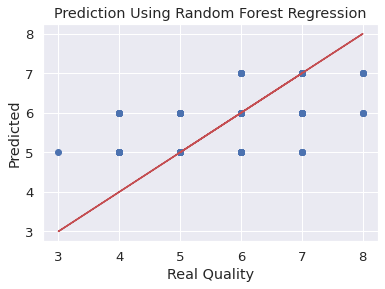

In [25]:
y_pred_test = pd.DataFrame({"y_pred": quality.y_pred_test, "y_pred_round":quality_pred_test_round, "y_test":quality.y_test})

plt.scatter(quality.y_test, quality_pred_test_round)
plt.plot(quality.y_test, quality.y_test, 'r')
plt.title("Prediction Using Random Forest Regression")
plt.xlabel("Real Quality")
plt.ylabel("Predicted")
plt.show()

In [26]:
# improve the model by grouping qualities

wine_group = wine_clean.copy()
wine_group['quality'].replace([3,4],['low','low'],inplace=True)
wine_group['quality'].replace([5,6],['medium','medium'],inplace=True)
wine_group['quality'].replace([7,8],['high','high'],inplace=True)

wine_group.head(5)

,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,sulphates,alcohol,quality
0,7.40,0.70,1.90,0.08,11.00,0.56,9.40,medium
1,7.80,0.88,2.60,0.10,25.00,0.68,9.80,medium
2,7.80,0.76,2.30,0.09,15.00,0.65,9.80,medium
3,11.20,0.28,1.90,0.07,17.00,0.58,9.80,medium
4,7.40,0.70,1.90,0.08,11.00,0.56,9.40,medium


In [27]:
# split the grouped quality dataset to train/test sets
train_set_g, test_set_g = train_test_split(wine_group, train_size=0.7, random_state=997)
X_train_g = train_set_g.drop(['quality'], axis=1, inplace = False)
y_train_g = train_set_g['quality']
X_test_g = test_set_g.drop(['quality'], axis=1, inplace = False)
y_test_g = test_set_g['quality']

# split dataset into X , y
X = wine_group.iloc[:,0:7]
y = wine_group.iloc[:,7]

# predict red wine quality groups with RandomForestClassifier
quality_g = classifier(X_train_g, y_train_g, X_test_g, y_test_g)
quality_g.GridSearch()
quality_g.fit_predict_RandomForest()

# Accuracy
print('Accuracy of the test set:', accuracy_score(y_test_g, quality_g.y_pred_test))

# cross validation
scores_test = cross_val_score(quality_g.cf_model, X, y, cv=10)

print("Cross validation accuracy scores : " + (10 * "{:.3f} ").format(*scores_test))
print(sum(scores_test)/len(scores_test))
print(np.std(scores_test))

Accuracy of the test set: 0.8132387706855791
Cross validation accuracy scores : 0.837 0.858 0.851 0.844 0.844 0.837 0.837 0.865 0.844 0.857 
0.8474164133738602
0.009538887372595607


Accuracy and mean squered error:
1. RandomForestRegressor: 0.640 (mean squared error 0.458)
2. RandomForestClassifier: cross validation mean accuracy  with grouping quality to low, medium and high: 0.847. Std = 0.010


Conclusions:
1. Random forest is better than just guessing the mean
2. There weren't strong correlations between the features and the target quality. This is why it is difficult to make an accurate predictions using regression
3. The dataset is slightly imbalanced which makes it diffucult to make predictions. It is suggested to reduce the number of classes by grouping
3. Solving this challenge as a classification task with grouping the quality levels seems to be a good approach